<a href="https://colab.research.google.com/github/bipinKrishnan/fastai_course/blob/master/cyclicLR_scratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import numpy as np
import scipy
import matplotlib.pyplot as plt

from random import random
from tqdm.notebook import tqdm

## Cyclical lr from scratch

In [2]:
def cyclical_lr_torch(epoch, step_size, base_lr, max_lr):
  cycle = torch.floor(torch.tensor([1]) + (epoch / (2*step_size)))
  x = torch.abs((epoch/step_size) - 2*cycle + 1)

  return (base_lr + (max_lr-base_lr) * torch.max(torch.tensor([0.0]), (1-x)))


In [3]:
def cyclical_lr_np(epoch, step_size, base_lr, max_lr):
  cycle = np.floor(1 + (epoch / (2*step_size)))
  x = np.abs((epoch/step_size) - 2*cycle + 1)

  return (base_lr + (max_lr-base_lr) * (np.max((0, (1-x)))))

In [ ]:
%time
for i in range(50):
  print(cyclical_lr_torch(torch.tensor([i]), torch.tensor([10.0]), torch.tensor([0.000001]), torch.tensor([0.003])))

In [ ]:
%time
for i in range(50):
  print(cyclical_lr_np(i, 10, 0.000001, 0.003))

In [6]:
lr = []
loss = []

for i in range(20):
  lr.append(cyclical_lr_np(i, 10, 0.001, 0.02))
  loss.append(random())

In [ ]:
plt.xticks(rotation=30)
plt.plot(lr, loss)

## Train a PyTorch model using above function

In [227]:
from torch import nn
from torchvision import datasets, models
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import transforms

In [248]:
transform = transforms.Compose([
                                transforms.ToPILImage(),
                                transforms.Grayscale(3),
                                transforms.ToTensor()                                
])

trainset = datasets.MNIST('./data', train=True, download=True)
valset = trainset = datasets.MNIST('./data', train=False, download=True)

In [261]:
class LoadData(Dataset):
  def __init__(self, data, target, transform):
    super().__init__()
    self.data = data
    self.target = target
    self.transform = transform

  def __len__(self):
    return len(self.data)

  def __getitem__(self, idx):
    return (self.transform(self.data[idx]), self.target[idx])


In [262]:
trainloader = DataLoader(LoadData(valset.data[:8000], valset.targets[:8000], transform), 32, shuffle=True)
valloader = DataLoader(LoadData(valset.data[8000:], valset.targets[8000:], transform), 32)

In [286]:
for data, label in trainloader:
  print(data.shape, label)
  break

for data, label in valloader:
  print(data.shape, label)
  break

torch.Size([32, 3, 28, 28]) tensor([5, 7, 6, 7, 7, 4, 4, 0, 7, 7, 3, 2, 9, 4, 1, 2, 5, 1, 7, 9, 8, 0, 6, 7,
        9, 2, 0, 1, 7, 3, 4, 4])
torch.Size([32, 3, 28, 28]) tensor([4, 9, 9, 7, 1, 1, 9, 0, 7, 8, 3, 4, 8, 6, 3, 8, 0, 9, 6, 2, 1, 0, 1, 0,
        6, 2, 3, 8, 9, 0, 7, 2])


In [267]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = models.resnet18(pretrained=False)

# for params in model.parameters():
#   params.requires_grad = False

model.fc = nn.Linear(model.fc.in_features, 10)

criterion = nn.CrossEntropyLoss()
opt = torch.optim.Adam(model.parameters())

In [268]:
model = model.to(device)

Training using cyclical lr

In [269]:
epochs = 8
losses = []
val_losses = []
lr = []
epoch_counter = -1

for i in tqdm(range(epochs), total=epochs, leave=False):
  model.train()
  for data, labels in tqdm(trainloader, total=len(trainloader), leave=False):
    epoch_counter += 1
    opt.param_groups[0]['lr'] = cyclical_lr_np(epoch_counter, 2*len(trainloader), 3e-3, 1e-2)

    opt.zero_grad()

    out = model(data.to(device))
    loss = criterion(out, labels.to(device))
    loss.backward()

    opt.step()

    losses.append(loss.item())
    lr.append(opt.param_groups[0]['lr'])

  model.eval()
  for valdata, vallabels in tqdm(valloader, total=len(valloader), leave=False):
    val_out = model(valdata.to(device))
    val_loss = criterion(val_out, vallabels.to(device))

    val_losses.append(val_loss.item())

  print(f"Epoch: {i+1}/{epochs}\ttrain_loss: {loss.item()}\tval_loss: {val_loss.item()}\t\n") 

Epoch: 1/8	train_loss: 0.5647634267807007	val_loss: 1.8559244871139526	



Epoch: 2/8	train_loss: 0.3552751839160919	val_loss: 0.7001129984855652	



Epoch: 3/8	train_loss: 0.004613920114934444	val_loss: 0.006507142446935177	



Epoch: 4/8	train_loss: 0.0008428222499787807	val_loss: 0.0005511415074579418	



Epoch: 5/8	train_loss: 0.18789464235305786	val_loss: 0.06165311858057976	



Epoch: 6/8	train_loss: 0.05297427251935005	val_loss: 0.003489276161417365	



Epoch: 7/8	train_loss: 0.03473542258143425	val_loss: 0.00199011224322021	



Epoch: 8/8	train_loss: 0.010251186788082123	val_loss: 0.0002185540070058778	



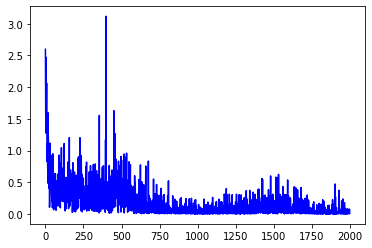

In [270]:
plt.plot(losses, 'b-')
# plt.plot(val_losses, 'r-')

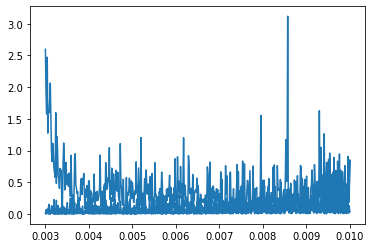

In [271]:
# plt.axes([0, 0, 1, 3])
plt.plot(lr, losses)
#plt.xscale('log')

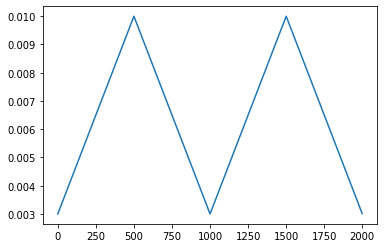

In [272]:
plt.plot(lr)

Training with out cyclical lr

In [273]:
model = models.resnet18(pretrained=False)

# for params in model.parameters():
#   params.requires_grad = False

model.fc = nn.Linear(model.fc.in_features, 10)

criterion = nn.CrossEntropyLoss()
opt = torch.optim.Adam(model.parameters(), lr=3e-2)

In [274]:
model = model.to(device)

In [275]:
epochs = 8
losses = []
val_losses = []

for i in tqdm(range(epochs), total=epochs, leave=False):
  model.train()
  for j, (data, labels) in tqdm(enumerate(trainloader), total=len(trainloader), leave=False):
    opt.zero_grad()

    out = model(data.to(device))
    loss = criterion(out, labels.to(device))
    loss.backward()

    opt.step()

    losses.append(loss.item())

  model.eval()
  for valdata, vallabels in tqdm(valloader, total=len(valloader), leave=False):
    val_out = model(valdata.to(device))
    val_loss = criterion(val_out, vallabels.to(device))

    val_losses.append(val_loss.item())

  print(f"Epoch: {i+1}/{epochs}\ttrain_loss: {loss.item()}\tval_loss: {val_loss.item()}\n") 

Epoch: 1/8	train_loss: 0.29624855518341064	val_loss: 0.6080714464187622



Epoch: 2/8	train_loss: 0.1813153773546219	val_loss: 0.061972152441740036



Epoch: 3/8	train_loss: 0.06702328473329544	val_loss: 0.013932319357991219



Epoch: 4/8	train_loss: 0.11177412420511246	val_loss: 0.021930737420916557



Epoch: 5/8	train_loss: 0.06177371367812157	val_loss: 0.03251802548766136



Epoch: 6/8	train_loss: 0.1952127069234848	val_loss: 0.004849531687796116



Epoch: 7/8	train_loss: 0.14782999455928802	val_loss: 0.004402864258736372



Epoch: 8/8	train_loss: 0.19639302790164948	val_loss: 0.0018085476476699114



## Fast ai

In [ ]:
!pip install fastai --upgrade

In [159]:
from fastai.vision.all import *

In [276]:
path = untar_data(URLs.MNIST)
path.ls()[1]

Path('/root/.fastai/data/mnist_png/training')

In [277]:
def splitter(x): return str(x.parent.parent.name) == 'testing'

db = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    get_y=parent_label
)

In [278]:
ds = db.datasets(path.ls()[0])

In [ ]:
ds.train, ds.valid

In [280]:
dls = db.dataloaders(path.ls()[0], bs=32)

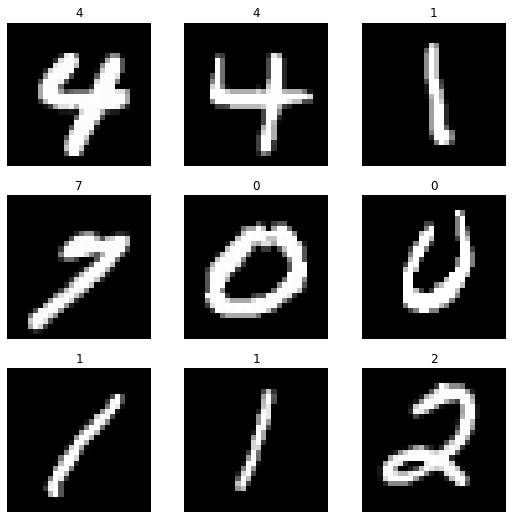

In [281]:
dls.show_batch()

In [ ]:
db.summary(path)

In [283]:
learn = Learner(dls, resnet18(pretrained=False), loss_func=CrossEntropyLossFlat(), metrics=accuracy)

SuggestedLRs(lr_min=0.02089296132326126, lr_steep=0.0010000000474974513)

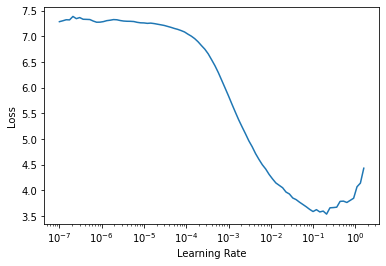

In [284]:
learn.lr_find()

In [285]:
learn.fit_one_cycle(8, base_lr=3e-3, max_lr=1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,0.350900,0.586152,0.840500,00:33
1,0.188595,0.284602,0.913000,00:33
2,0.213820,0.122601,0.962500,00:33
3,0.102351,0.079087,0.977000,00:33
4,0.072047,0.083941,0.976500,00:33
5,0.026256,0.040823,0.985500,00:33
6,0.013390,0.030870,0.989000,00:33
7,0.004982,0.028754,0.990000,00:33
